In [1]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import ruamel.yaml as yaml
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from src.neural_networks.encoder import BaseEncoder
from src.neural_networks.decoder import BaseDecoder

/home/daniel/Documents/app-e-phy/mi-csi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
## Function for data import

def import_data(path):
    input_data = np.load(path)
    input_data = np.swapaxes(input_data, 1, 2)
    input_data = input_data[:512000,:,:]
    print("Data:", np.shape(input_data))

    train_size, val_size, test_size = int(0.6*input_data.shape[0]), int(0.2*input_data.shape[0]), int(0.2*input_data.shape[0])

    train_dataset, val_dataset, test_dataset = [input_data[i] for i in range(train_size)], [input_data[i] for i in range(train_size, train_size+val_size)], [input_data[i] for i in range(train_size+val_size, train_size+val_size+test_size)]

    print("Train:", train_size)
    print("Val:", val_size)
    print("Test:", test_size)
    print("Total:", train_size+val_size+test_size)
    print()

    return train_dataset, val_dataset, test_dataset

In [32]:
## Model paths and parameter configurations

sh_folder = "958455dc2ffe435aa08887c9376364a1"
ex_folder = "067f7abb379d4d9088e050d8ff6d4468"

with open("conf/share_conf.yaml", "r") as f:
    conf_sh = yaml.safe_load(f)
with open("conf/exclusive_conf.yaml", "r") as f:
    conf_ex = yaml.safe_load(f)

MODEL_PARAM = conf_sh["model_param"]
MODEL_PARAM_EX = conf_ex["model_param"]

img_size=MODEL_PARAM["img_size"]
channels=MODEL_PARAM["channels"]
shared_dim=MODEL_PARAM["shared_dim"]
exclusive_dim=MODEL_PARAM_EX["exclusive_dim"]
switched=MODEL_PARAM["switched"]

In [33]:
## Model definition

model_sh_x = BaseEncoder(
    img_size=img_size,
    in_channels=channels,
    num_filters=64,
    kernel_size=5,
    repr_dim=shared_dim,
)

model_sh_y = BaseEncoder(
    img_size=img_size,
    in_channels=channels,
    num_filters=64,
    kernel_size=5,
    repr_dim=shared_dim,
)

model_ex_x = BaseEncoder(
    img_size=img_size,
    in_channels=channels,
    num_filters=64,
    kernel_size=5,
    repr_dim=exclusive_dim,
)

model_ex_y = BaseEncoder(
    img_size=img_size,
    in_channels=channels,
    num_filters=64,
    kernel_size=5,
    repr_dim=exclusive_dim,
)

model_dec_x = BaseDecoder(
    img_size=img_size,
    kernel_size=5,
    repr_dim=shared_dim,
)

model_dec_y = BaseDecoder(
    img_size=img_size,
    kernel_size=5,
    repr_dim=shared_dim,
)

## Import weights from training

model_sh_x.load_state_dict(torch.load("mlruns/1/"+sh_folder+"/artifacts/sh_encoder_x/state_dict.pth", map_location=device))
model_sh_x.eval()

model_sh_y.load_state_dict(torch.load("mlruns/1/"+sh_folder+"/artifacts/sh_encoder_y/state_dict.pth", map_location=device))
model_sh_y.eval()

model_dec_x.load_state_dict(torch.load("mlruns/1/"+sh_folder+"/artifacts/decoder_x/state_dict.pth", map_location=device))
model_dec_x.eval()

model_dec_y.load_state_dict(torch.load("mlruns/1/"+sh_folder+"/artifacts/decoder_y/state_dict.pth", map_location=device))
model_dec_y.eval()

#model_ex_x.load_state_dict(torch.load("mlruns/2/"+ex_folder+"/artifacts/ex_encoder_x/state_dict.pth", map_location=device))
#model_ex_x.eval()

#model_ex_y.load_state_dict(torch.load("mlruns/2/"+ex_folder+"/artifacts/ex_encoder_y/state_dict.pth", map_location=device))
#model_ex_y.eval()

BaseDecoder(
  (linear1): Linear(in_features=2, out_features=14, bias=True)
  (deconv1): ConvTranspose1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (upsample1): Upsample(size=28, mode=nearest)
  (deconv2): ConvTranspose1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (upsample2): Upsample(size=56, mode=nearest)
  (deconv3): ConvTranspose1d(32, 1, kernel_size=(5,), stride=(1,), padding=(2,))
)

In [6]:
# Load data
print("Loading Alice data:")
alice_train, alice_val, alice_test = import_data('../data/phase_dataset_alice.npy')
print("Loading Bob data:")
bob_train, bob_val, bob_test = import_data('../data/phase_dataset_bob.npy')

Loading Alice data:
Data: (512000, 1, 56)
Train: 307200
Val: 102400
Test: 102400
Total: 512000

Loading Bob data:
Data: (512000, 1, 56)
Train: 307200
Val: 102400
Test: 102400
Total: 512000



In [7]:
alice_test_2 = np.load('../data/alice_phase_small.npy')
alice_test_2 = np.swapaxes(alice_test_2, 1, 2)
bob_test_2 = np.load('../data/bob_phase_small.npy')
bob_test_2 = np.swapaxes(bob_test_2, 1, 2)

In [16]:
def disentangle_csi(alice_data, bob_data, number_of_samples):
    alice_shared = []
    bob_shared = []
    alice_exclusive = []
    bob_exclusive = []
    phase_correlation = []
    shared_correlation = []
    exclusive_correlation = []

    ## Get shared and exclusive data

    for index in tqdm(range(number_of_samples)):
        #s = random.randint(0, len(alice_test))

        img_x = alice_data[index]
        img_y = bob_data[index]

        ## Normalize measurements

        norm_x = (img_x[0] - np.mean(img_x[0])) / np.std(img_x[0])
        norm_y = (img_y[0] - np.mean(img_y[0])) / np.std(img_y[0])

        ## Correlation of normalized measurements

        phase_correlation.append(np.correlate(norm_x, norm_y))

        ## Extract shared data for x and y

        sh_x = model_sh_x(torch.Tensor(img_x[None, :]))[0].detach().numpy()[0]
        sh_y = model_sh_y(torch.Tensor(img_y[None, :]))[0].detach().numpy()[0]

        ## Extract exclusive data for x and y
        
        ex_x = model_ex_x(torch.Tensor(img_x[None, :]))[0].detach().numpy()[0]
        ex_y = model_ex_y(torch.Tensor(img_y[None, :]))[0].detach().numpy()[0]

        ## Save values

        alice_shared.append(sh_x)
        bob_shared.append(sh_y)
        alice_exclusive.append(ex_x)
        bob_exclusive.append(ex_y)

        ## Normalize values and compute correlation

        norm_sh_x = (sh_x - np.mean(sh_x)) / np.std(sh_x)
        norm_sh_y = (sh_y - np.mean(sh_y)) / np.std(sh_y)

        shared_correlation.append(np.correlate(norm_sh_x, norm_sh_y))

        ## Normalize values and compute correlation

        norm_ex_x = (ex_x - np.mean(ex_x)) / np.std(ex_x)
        norm_ex_y = (ex_y - np.mean(ex_y)) / np.std(ex_y)

        exclusive_correlation.append(np.correlate(norm_ex_x, norm_ex_y))

    alice_shared = np.array(alice_shared)
    bob_shared = np.array(bob_shared)
    alice_exclusive = np.array(alice_exclusive)
    bob_exclusive = np.array(bob_exclusive)

    return alice_shared, alice_exclusive, bob_shared, bob_exclusive, phase_correlation, shared_correlation, exclusive_correlation

In [34]:
alice_shared, alice_exclusive, bob_shared, bob_exclusive, phase_correlation, shared_correlation, exclusive_correlation = disentangle_csi(alice_test, bob_test, 10000)

100%|██████████| 10000/10000 [00:50<00:00, 197.55it/s]


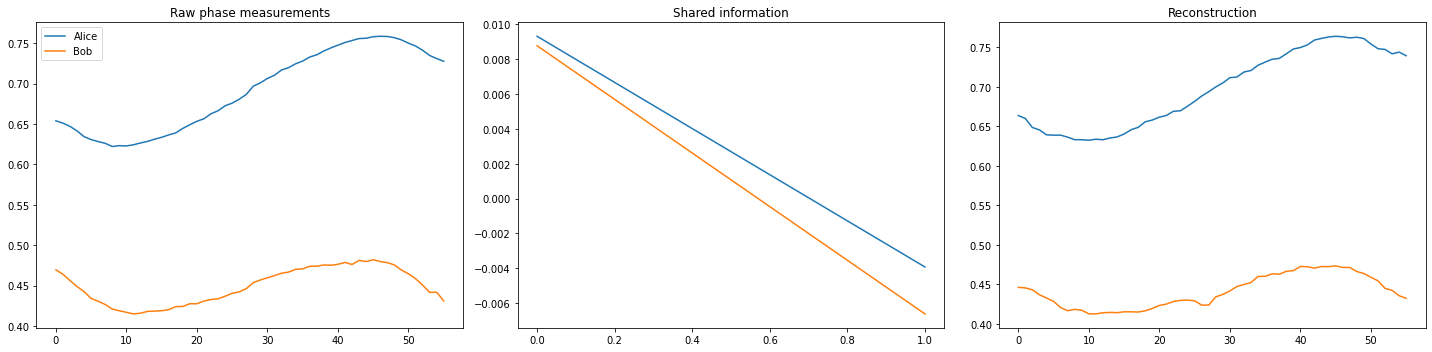

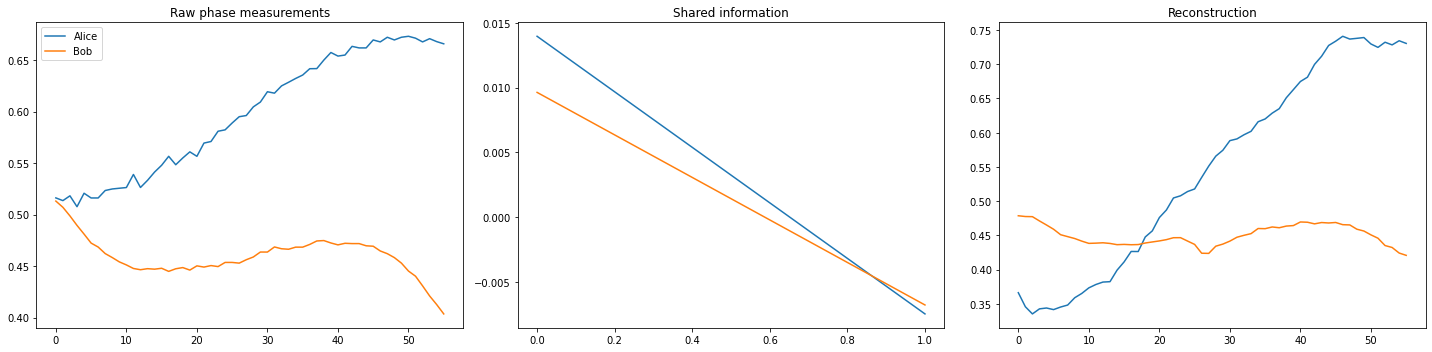

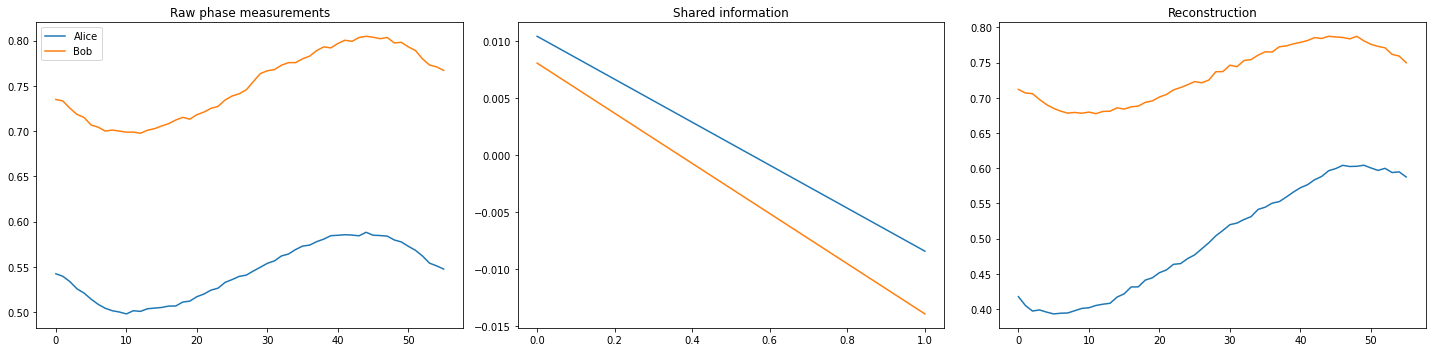

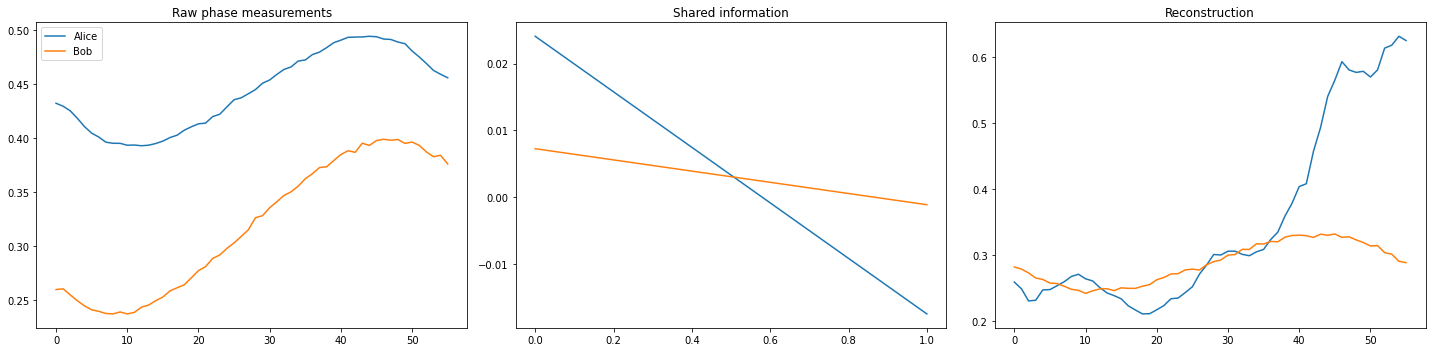

KeyboardInterrupt: 

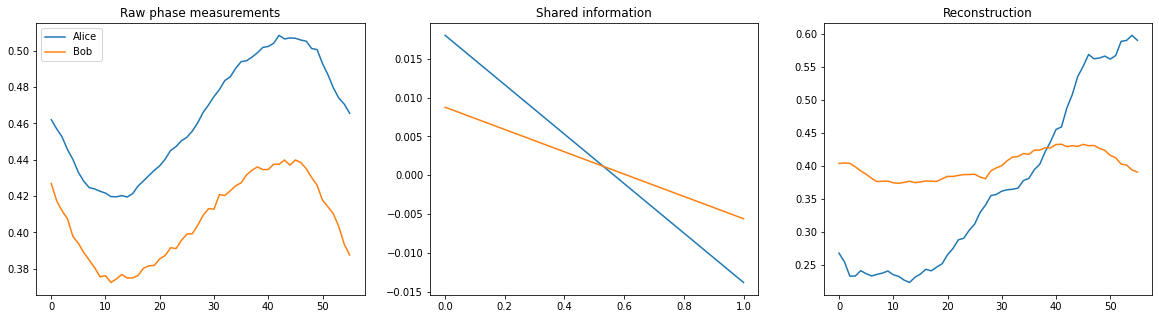

In [39]:
## Plot measurement, shared and exclusive in one plot
for i in range(5):
    s = random.randint(0, len(alice_shared))
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    img_x = alice_test[s]
    img_y = bob_test[s]

    axs[0].plot(img_x[0, :], label="Alice")
    axs[0].plot(img_y[0, :], label="Bob")
    axs[0].set_title("Raw phase measurements")
    axs[0].legend()

    axs[1].plot(alice_shared[s])
    axs[1].plot(bob_shared[s])
    axs[1].set_title("Shared information")

    rec_input_x = alice_shared[s]
    rec_input_x = rec_input_x[None, :]
    rec_x = model_dec_x(torch.Tensor(rec_input_x))[0].detach().numpy()[0]

    rec_input_y = bob_shared[s]
    rec_input_y = rec_input_y[None, :]
    rec_y = model_dec_y(torch.Tensor(rec_input_y))[0].detach().numpy()[0]

    axs[2].plot(rec_x)
    axs[2].plot(rec_y)
    axs[2].set_title("Reconstruction")

    plt.tight_layout()
    #plt.savefig("figs/" + str(i) + ".png")
    plt.show()
    plt.close()

100%|██████████| 1000/1000 [00:03<00:00, 276.55it/s]


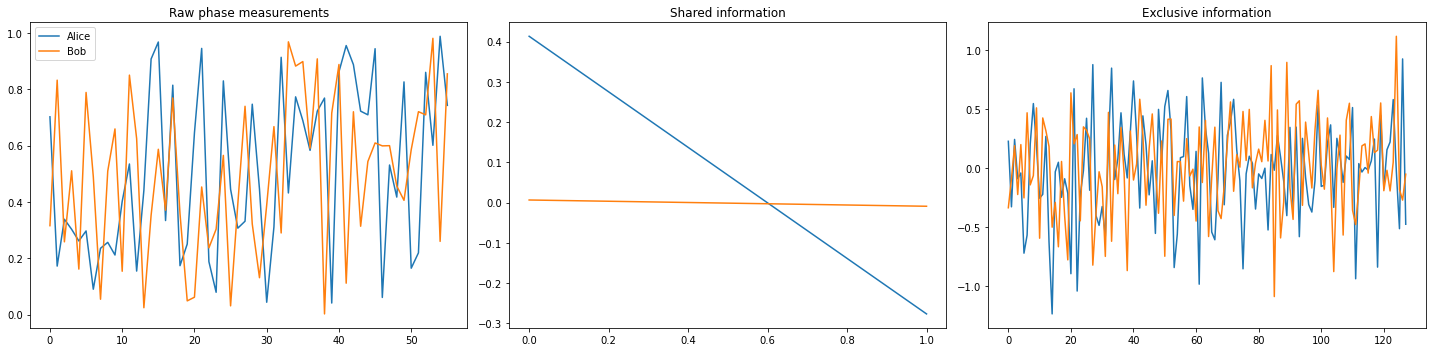

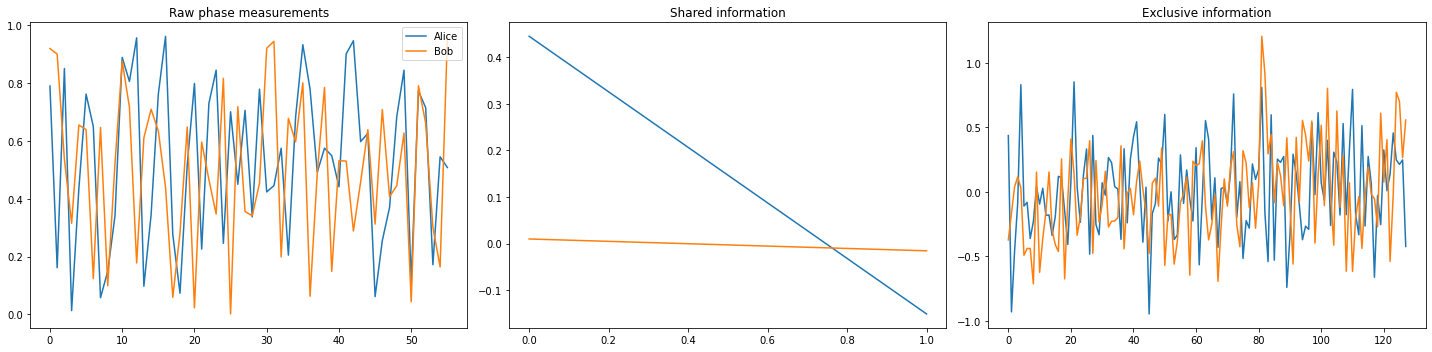

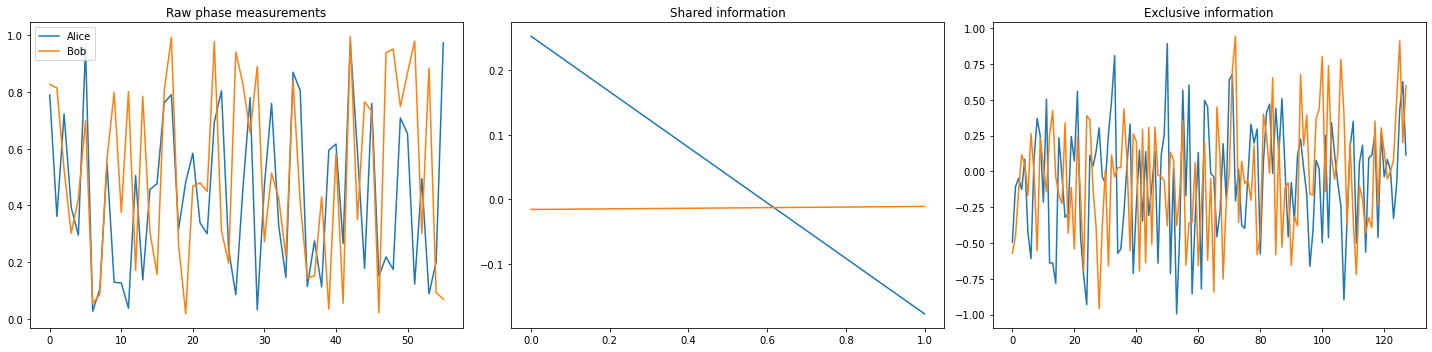

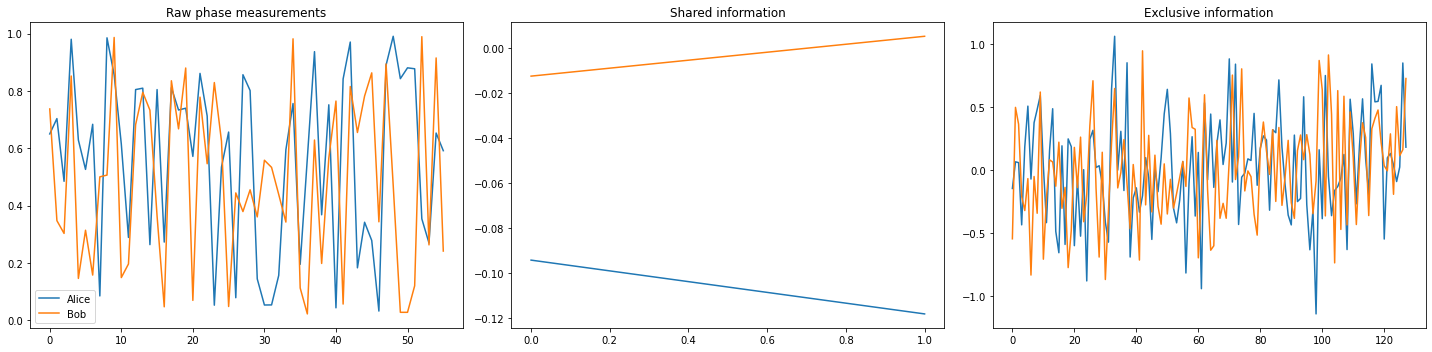

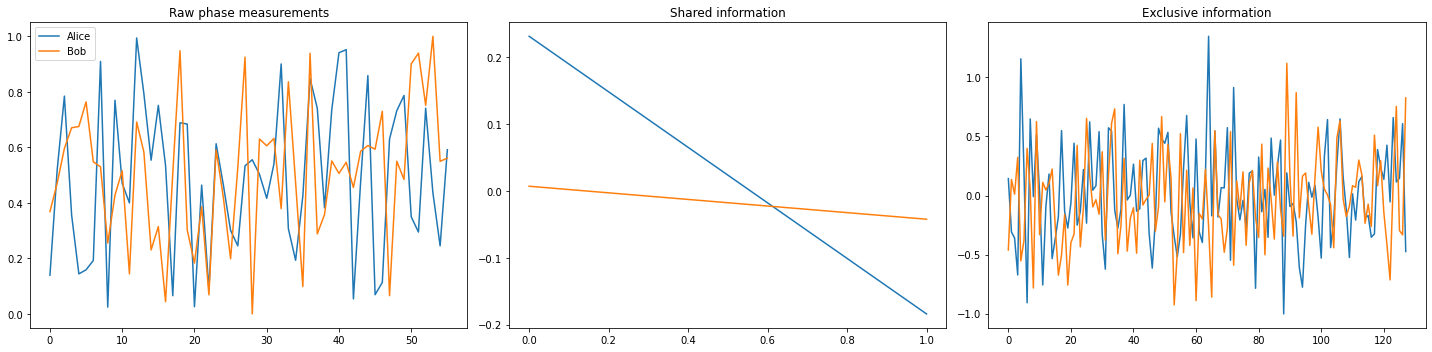

In [36]:
alice_random = []
bob_random = []
for _ in range(1000):
    alice_random.append(np.random.rand(1, 56))
    bob_random.append(np.random.rand(1, 56))

#for _ in range(1000):
#    alice_random.append(np.linspace(-2, 2, 56).reshape(1, -1))
#    #bob_random.append(np.random.rand(1, 56))
#bob_random = alice_random


alice_random_shared, alice_random_exclusive, bob_random_shared, bob_random_exclusive, _, _, _ = disentangle_csi(alice_random, bob_random, 1000)

for s in range(5):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    axs[0].plot(alice_random[s][0], label="Alice")
    axs[0].plot(bob_random[s][0], label="Bob")
    axs[0].set_title("Raw phase measurements")
    axs[0].legend()

    axs[1].plot(alice_random_shared[s])
    axs[1].plot(bob_random_shared[s])
    axs[1].set_title("Shared information")

    axs[2].plot(alice_random_exclusive[s])
    axs[2].plot(bob_random_exclusive[s])
    axs[2].set_title("Exclusive information")

    plt.tight_layout()
    plt.show()
    plt.close()

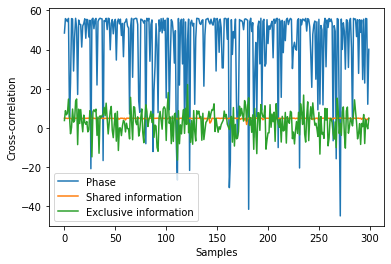

In [30]:
## Plot correlation
plt.plot(phase_correlation[:300], label="Phase")
plt.plot(shared_correlation[:300], label="Shared information")
plt.plot(exclusive_correlation[:300], label="Exclusive information")
plt.xlabel("Samples")
plt.ylabel("Cross-correlation")
plt.legend()
#plt.savefig("figs/corr.jpg")
plt.show()

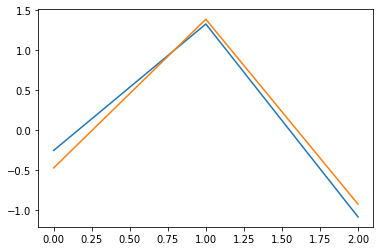

In [15]:
### KEY

s = random.randint(0, 1000)
alice_shared_key = (alice_shared[s] - np.mean(alice_shared[s])) / np.std(alice_shared[s])
bob_shared_key = (bob_shared[s] - np.mean(bob_shared[s])) / np.std(bob_shared[s])

#alice_shared_key = savgol_filter(alice_shared_key, 14, 3) # window size 51, polynomial order 3
#bob_shared_key = savgol_filter(bob_shared_key, 14, 3) # window size 51, polynomial order 3

plt.plot(alice_shared_key)
plt.plot(bob_shared_key)
plt.show()
plt.close()

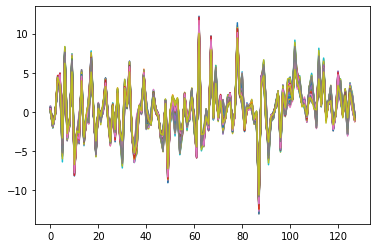

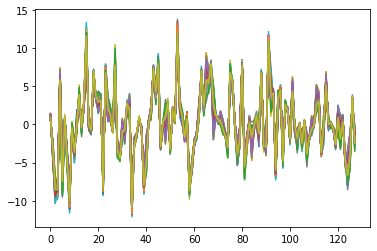

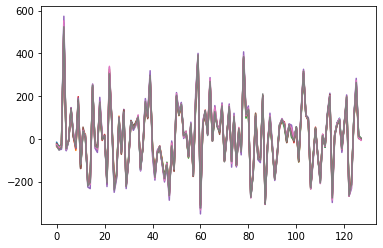

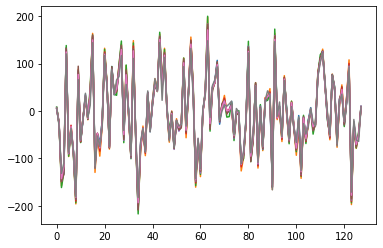

In [32]:
### FINGERPRINT

for i in range(200):
    new = np.mean(alice_exclusive[i*128:i*128+128, :], axis=0)
    plt.plot(new)
plt.show()
#plt.savefig("figs/alice_avg.png")
plt.close()

for i in range(200):
    new = np.mean(bob_exclusive[i*128:i*128+128, :], axis=0)
    plt.plot(new)
plt.show()
#plt.savefig("figs/bob_avg.png")
plt.close()

for i in range(200):
    new = np.mean(alice_random_exclusive[i*128:i*128+128, :], axis=0)
    plt.plot(new)
plt.show()
#plt.savefig("figs/alice_avg.png")
plt.close()

for i in range(200):
    new = np.mean(bob_random_exclusive[i*128:i*128+128, :], axis=0)
    plt.plot(new)
plt.show()
#plt.savefig("figs/bob_avg.png")
plt.close()

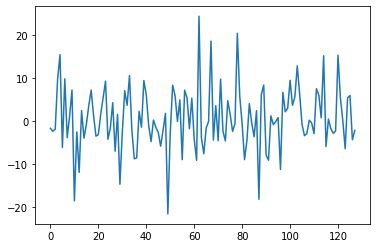

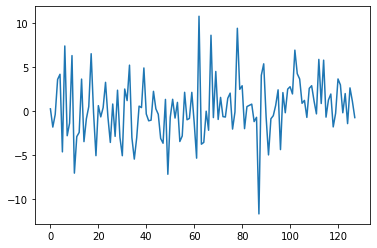

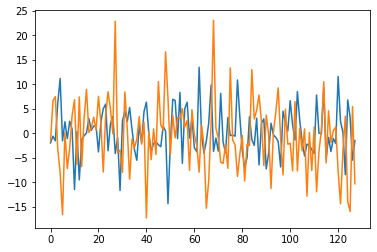

In [44]:
fp_alice = np.mean(alice_exclusive[0:128, :], axis=0)
diff = alice_exclusive[0] - fp_alice

plt.plot(alice_exclusive[0])
plt.show()
plt.close()
plt.plot(fp_alice)
plt.show()
plt.close()
plt.plot(diff)

fp_bob = np.mean(bob_exclusive[0:128, :], axis=0)
diff = bob_exclusive[0] - fp_bob

plt.plot(diff)

In [23]:
print(alice_test_2.shape)
alice_shared_2, alice_exclusive_2, bob_shared_2, bob_exclusive_2, _, _, _ = disentangle_csi(alice_test_2, bob_test_2, alice_test_2.shape[0])

(166, 1, 56)


100%|██████████| 166/166 [00:00<00:00, 634.83it/s]


In [105]:
def quantize(input, n_pkt, w):
    key_bitstring = []
    # quantize
    for i in range(n_pkt // w):
        key_bitstring += list(map(int, input[i*w:i*w+w] > np.mean(input[i*w:i*w+w])))

    # quantize remaining
    if(n_pkt % w != 0):
        key_bitstring += list(map(int, input[w*(n_pkt//w):n_pkt] > np.mean(input[w*(n_pkt//w):n_pkt])))
    
    return key_bitstring

def bin_to_pw(input, n_pkt):
    passphrase = ""
    # HEX MAPPING
    # UTF-8 / lowercase HEX / uppercase HEX
    for i in range(n_pkt//8):
        if(int(input[i*8:i*8+8], 2) <= 0x20):
            passphrase += hex(int(input[i*8:i*8+8], 2))[2:].upper()
        elif(int(input[i*8:i*8+8], 2) >= 0x80):
            passphrase += hex(int(input[i*8:i*8+8], 2))[2:].lower()
        else:
            passphrase += chr(int(input[i*8:i*8+8], 2))
    return passphrase

def hex_to_pw(input):
    passphrase = ""
    # HEX MAPPING
    # UTF-8 / lowercase HEX / uppercase HEX
    for i in range(len(input)):
        if(int(input[i], 16) <= 0x20):
            passphrase += hex(int(input[i], 16))[2:].upper()
        elif(int(input[i], 16) >= 0x80):
            passphrase += hex(int(input[i], 16))[2:].lower()
        else:
            passphrase += chr(int(input[i], 16))
    return passphrase

def phase_to_key(input, n, w):

    # quantize shared secret and convert to string
    quantized_input = quantize(input, n, w)
    quantized_input = "".join(str(x) for x in quantized_input)
    key = bin_to_pw(quantized_input, n)
    return key
    # use quantized string to generate key with HKDF
    prk = hkdf_extract(b"", str.encode(key))
    key = hkdf_expand(prk, b"", 16)
    key = key.hex()
    key = [key[i:i+2] for i in range(0, len(key), 2)]
    key = hex_to_pw(key)

    return key

def get_avg(data):
    return np.mean(data[:, :], axis=0)

In [127]:
w = 6
nf = 128
avg_range = 128

['9aDka9c7<b4b2Tb288e3_8cacd6', 'baDka9c7<b4b2Tb288e3_8ca4d6', '9aDka9c7<b4b2T288e7_8cacd6', '1ADcba9c79cbcb2146Ac7_88acd6', '1ADcba9c59cbc9a157Acf_88ac96', '9aDka9c7<b492T388e7_8cacd6', '1ADcba9c71Cbcb2T688c7_8cacd6', '1ADcba9c59cbc92157Ac7_88acd6', '9aDKa9c71Cbc92T388e7_8cacd6', '9aDka9c7<b4b2T288e3_8cacd6', '9aDcfa9c59c9cd2U38cf_8cacd6', '9aDka9c7<b4b2Tb288e3_8ca4d6', '1ADcba9c79cbcb2146Ac7_8cacd6', '9aDka9c7<b4b2T388e7_8cacd6', '9aDeba9c7<bcb2T388c7_8cacd6', 'baDka9c7<94b2Tb288e3_8ca4c6', '9aDka9c7<b492T388e3_8cacd6', '1ADcba9c59cbc92U7Ac7_8cacd6', '9aDka9c7<9492T388e3_8cacd6', '9aDka9c7<9492Tb388e3_8cacc6', '9aDKa9c71C94d2T388e7_8cacd6', '1ADcba9c79cbcb21468ac7_8cacd6', '9aDka9c71Cbc92T388e7_8cacd6', '1ADeba9c79cbcb2147Ac7_88acd6', '1ADcba9c79cbcba146Ac7_88acd6', 'baDka9c7<9492Tb288e3_8ca4c6', '9aDka9c7<94d2Tb388e3_8cacc6', '1ADka9c7<b4b2Tb288e3_8ca4c6', '1ADka9c7<b4b2T288e3_8cacd6', '9aDka9c7<b492Tb388e3_8cacd6', '9aDcba9c79c9cd2T388c7_8cacd6', '1ADcba9c79cbcba146Ac7_88ac96', '1A

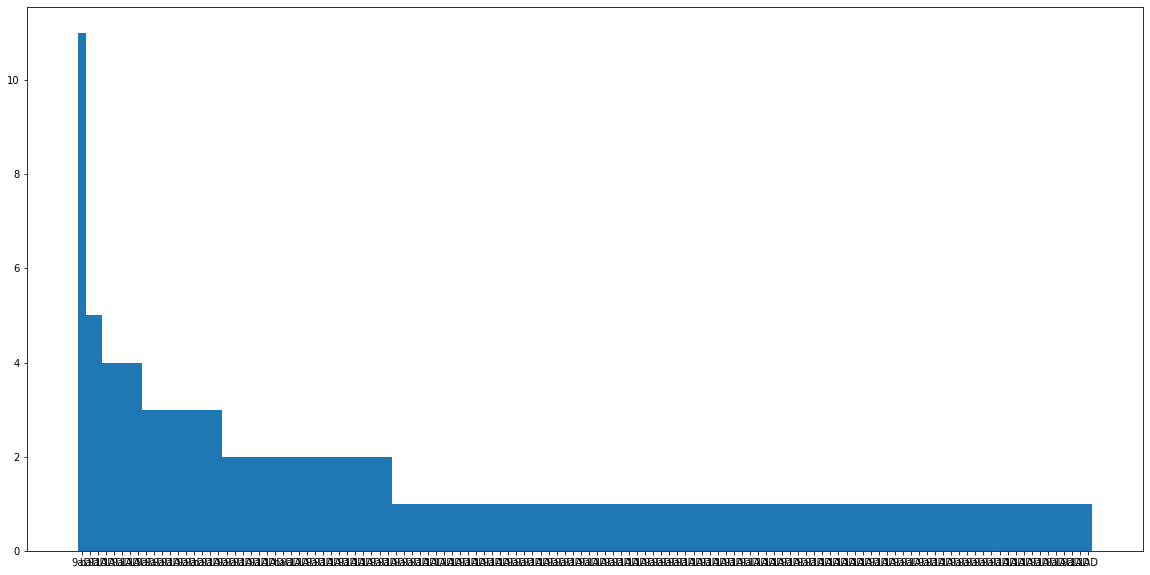

9aDka9c7<b4b2Tb288e3_8cacd6


In [130]:
fp_collection = []
for _ in range(200):
    s = random.randint(0, alice_exclusive.shape[0]-avg_range)
    alice_fp = get_avg(alice_exclusive[s:s+avg_range, :])
    bob_fp = get_avg(bob_exclusive[s:s+avg_range, :])

    #alice_fp = savgol_filter(alice_fp, 14, 3) # window size 51, polynomial order 3

    #plt.plot(alice_fp)
    #plt.show()
    #plt.close()

    alice_fp = phase_to_key(alice_fp, nf, w)
    bob_fp = phase_to_key(bob_fp, nf, w)
    #sss = int(alice_fp, 2)

    '''
    s = random.randint(0, alice_exclusive_2.shape[0]-avg_range)
    alice_fp = compute_fingerprint(alice_exclusive_2[s:s+avg_range, :])
    bob_fp = compute_fingerprint(bob_exclusive_2[s:s+avg_range, :])
    plt.plot(alice_fp)
    plt.plot(bob_fp)
    plt.show()
    plt.close()
    '''

    #print("Alice's fingerprint:", alice_fp)
    #print("Bob's fingerprint:", bob_fp)
    fp_collection.append(alice_fp)

sorted_list_raw = sorted(fp_collection, key=fp_collection.count, reverse=True)
sorted_list = list(dict.fromkeys(sorted_list_raw))
print(sorted_list)

print(len(sorted_list))
plt.figure(figsize=(20,10))
plt.hist(sorted_list_raw, bins=np.arange(len(sorted_list)+1)-0.5)
plt.xticks(range(len(sorted_list)), [x[:3] for x in sorted_list])
plt.show()
#print(max(sorted_list, key=fp_collection.count))
print(sorted_list[0])

In [118]:
right = 0
wrong = 0
nk=3
for _ in range(1000):
    # quantize shared secret and convert to string
    s = random.randint(0, alice_shared.shape[0]-avg_range)
    alice_shared_key = get_avg(alice_shared[s:s+avg_range, :])
    bob_shared_key = get_avg(bob_shared[s:s+avg_range, :])

    key_a = phase_to_key(alice_shared_key, nk, w)
    key_b = phase_to_key(bob_shared_key, nk, w)

    #print("Alice's key:", key_a)
    #print("Bob's key:", key_b)
    #print(key_a == key_b)
    if(key_a == key_b):
        right += 1
    else:
        wrong += 1
print(right, wrong, right*100/(right+wrong))

1000 0 100.0


[[-0.00139701 -0.00136699]
 [-0.0011661   0.00101915]
 [-0.0010542  -0.001181  ]
 ...
 [-0.00133521 -0.00088454]
 [-0.00117904  0.00056843]
 [-0.00127738 -0.00144099]]
[[-6.7033747e-04  1.2590142e-04]
 [-7.6325651e-04  6.2446285e-05]
 [-7.5564499e-04  7.8313780e-05]
 ...
 [-5.1073986e-04 -6.4866101e-05]
 [-6.4373045e-04  1.3721801e-04]
 [-7.0016593e-04  1.1410391e-04]]


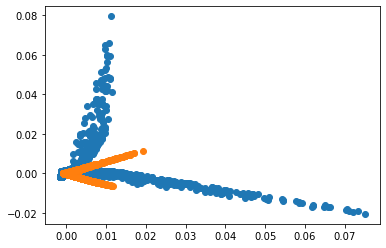

In [28]:
## PCA
pca = PCA(n_components=2)

principalComponents_x = pca.fit_transform(alice_shared)
principalComponents_y = pca.fit_transform(bob_shared)
print(principalComponents_x)
print(principalComponents_y)
plt.scatter(principalComponents_x[:, 0], principalComponents_x[:, 1])
plt.scatter(principalComponents_y[:, 0], principalComponents_y[:, 1])
plt.show()